# Transfer Learning

Transfer Learning is the re-use of pretrained models on new tasks. Most often, the two tasks are different but somehow related to each other. For example, a model which was trained on image classification might have learnt image features which can also be harnessed for other image related tasks. This technique became increasingly popular in the field of Deep Learning since it enables one to train a model on comparatively little data.

Parts of this notebook are based on the tutorial by Sasank Chilamkurthy (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [50]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from transfer_learning import visualize_model, imshow, train_model

### Create dataloaders which loads images from a local folder with the following structure

```
data/hymenoptera_data
│
└───train
│     │
│     │───ants
│     │    │   ant111.png
│     │    │   ant_small.png
│     │    └   ...
│     │
│     └───bees
│          │   bee1.png
│          │   bee_yellow.png
│          └   ...
│   
└───val
      │───ants
      │    │   ant111_val.png
      │    │   ant_small2.png
      │    └   ...
      │
      └───bees
           │   bee1_val.png
           │   bee_black.png
           └   ...
```

### Data Augmentation

In the training dataloader, we can very easily add preprocessing steps to augment the data (scaling, flipping, etc.)

In [1]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # randomly crops and scales it
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("dataset_sizes: \n%s\n" % dataset_sizes)
class_names = image_datasets['train'].classes
print("class_names: \n%s\n" % class_names)

device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'transforms' is not defined

### Visualize some training images

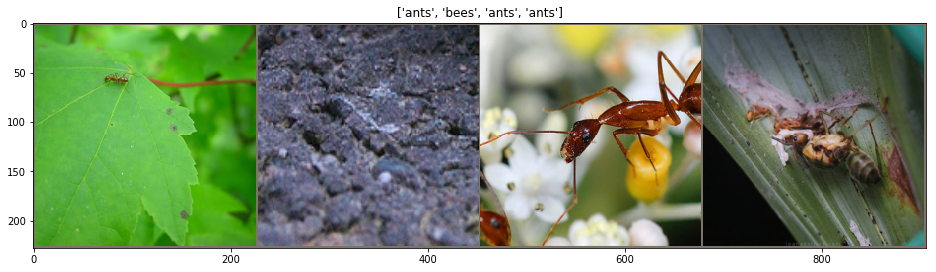

In [53]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16, 9))
imshow(out, title=[class_names[x] for x in classes])

### Load a pretrained model

#### List of available models

In [54]:
from torchvision import models
print(dir(models))

['AlexNet', 'DenseNet', 'Inception3', 'ResNet', 'SqueezeNet', 'VGG', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception', 'inception_v3', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


ResNet-18:

![](./transfer_learning/resnet.png)

In [55]:
model_ft = models.resnet18(pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Last fully connected layer has a 1000 output neurons (has been trained on ImageNet which consists of 1000 categories).

In [56]:
num_ftrs = model_ft.fc.in_features
print("num_features: \n%s\n" % model_ft.fc.in_features)
print("num_outputs: \n%s\n" % model_ft.fc.out_features)

num_features: 
512

num_outputs: 
1000



Since we want to perform binary classification (bees/ants), let's replace the last fully-connected layer by a new layer with only two output units:

In [57]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [58]:
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

#### Eventually, we also have to define a loss function and an optimizer

In [59]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()  # train it with CrossEntropyLoss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [61]:
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler, device,
                       num_epochs=25)

Epoch 0/24
----------


Process Process-64:
Process Process-63:
Process Process-61:
Process Process-62:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
Traceback (most recent call last):
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4

KeyboardInterrupt: 

  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
KeyboardInterrupt
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._arg

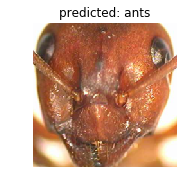

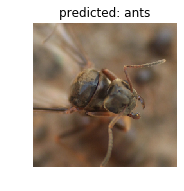

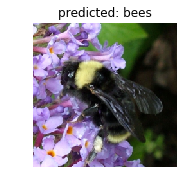

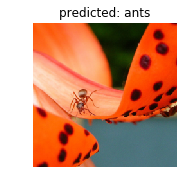

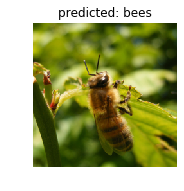

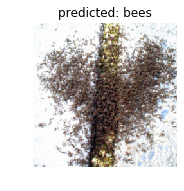

In [77]:
visualize_model(model_ft, dataloaders, device, class_names)

### Before, we retrained the _full_ network on our new task. Let's now freeze all layers except for the last one

In [79]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [81]:
model_conv = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv,
                         exp_lr_scheduler, device, num_epochs=25)

Epoch 0/24
----------


Process Process-128:
Process Process-125:
Process Process-127:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-126:
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/site-packages/t

KeyboardInterrupt: 

  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/andreas/anaconda3/envs/pytorch-0.4/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready =

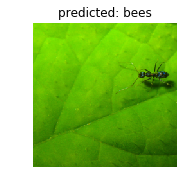

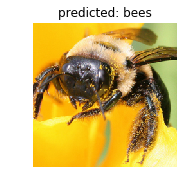

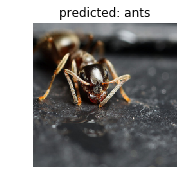

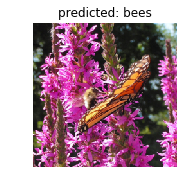

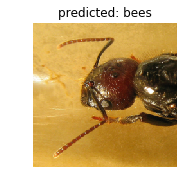

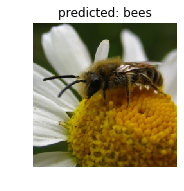

In [82]:
visualize_model(model_conv, dataloaders, device, class_names)

plt.ioff()
plt.show()